In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam



In [4]:
clothes_info = ['bluejeans', 'coat', 'knit', 'longpants', 'longtshirt', 'padding',
          'shirt', 'shorts', 'shortT', 'skirt', 'socks']


# data augmentation

In [5]:
base_dir = '/content/drive/MyDrive/ktintern/datasets'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [19]:
input_size = (299, 299)

train_datagen = ImageDataGenerator(rescale=1./255.,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=20,
                                                  class_mode='categorical',
                                                  target_size=input_size)

validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                      batch_size=20,
                                                      class_mode='categorical',
                                                      target_size=input_size)

test_generator = test_datagen.flow_from_directory(validation_dir,
                                                      batch_size=20,
                                                      class_mode='categorical',
                                                      target_size=input_size)

Found 330 images belonging to 11 classes.
Found 110 images belonging to 11 classes.
Found 110 images belonging to 11 classes.


## basic CNN model

In [25]:
basic_cnn_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(11, activation='softmax')
])

basic_cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 148, 148, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 73, 73, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 71, 71, 64)        36928     
                                                                 
 flatten_5 (Flatten)         (None, 322624)           

In [34]:
basic_cnn_model.compile(optimizer=Adam(lr=0.1),
            loss='categorical_crossentropy',
            metrics = ['accuracy']
            )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

checkpoint_path = '/content/drive/MyDrive/ktintern/models/'
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_path, 'basic_cnn_model.ckpt'),
                                                   save_weights_only=True,
                                                   monitor = 'val_loss',
                                                   verbose=1,
                                                   save_best_only=True
                                                  ) 

In [37]:
basic_cnn_history = basic_cnn_model.fit(train_generator,
                                        validation_data=validation_generator,
                                        epochs=30,
                                        callbacks=[cb_checkpoint, early_stopping]
                                        )

Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 2.4162 - accuracy: 0.0697
Epoch 00001: val_loss improved from inf to 2.40223, saving model to /content/drive/MyDrive/ktintern/models/basic_cnn_model.ckpt
17/17 [==============================] - 64s 4s/step - loss: 2.4162 - accuracy: 0.0697 - val_loss: 2.4022 - val_accuracy: 0.1000
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 2.4083 - accuracy: 0.0697
Epoch 00002: val_loss improved from 2.40223 to 2.40155, saving model to /content/drive/MyDrive/ktintern/models/basic_cnn_model.ckpt
17/17 [==============================] - 63s 4s/step - loss: 2.4083 - accuracy: 0.0697 - val_loss: 2.4015 - val_accuracy: 0.1000
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 2.4211 - accuracy: 0.0697
Epoch 00003: val_loss did not improve from 2.40155
17/17 [==============================] - 61s 4s/step - loss: 2.4211 - accuracy: 0.0697 - val_loss: 2.4025 - val_accuracy: 0.0800
Epoch 4/30
17/17 [==

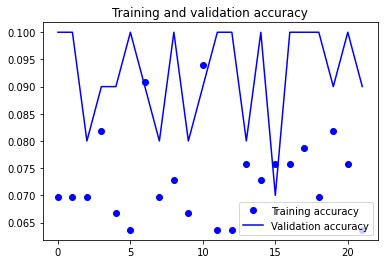

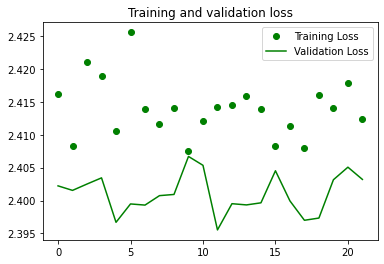

In [41]:
acc = basic_cnn_history.history['accuracy']
val_acc = basic_cnn_history.history['val_accuracy']
loss = basic_cnn_history.history['loss']
val_loss = basic_cnn_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                       batch_size=20,
                                                       class_mode  = 'categorical',
                                                       target_size = (150, 150))

## transfer learning - inception v3 , just classifier

In [43]:
inceptioinV3 = tf.keras.applications.InceptionV3(include_top=True)
base_inputs = inceptioinV3.layers[0].input
base_outputs = inceptioinV3.layers[-2].output
classifier = tf.keras.layers.Dense(11)(base_outputs)
inceptioinV3_model = tf.keras.Model(inputs=base_inputs, outputs=classifier)

inceptioinV3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_112 (Conv2D)            (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_112[0][0]']             
 ormalization)                  )                                                             

In [44]:
inceptioinV3_model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


In [45]:
checkpoint_path = '/content/drive/MyDrive/ktintern/models/'
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_path, 'inceptionV3_model.ckpt'),
                                                   save_weights_only=True,
                                                   monitor = 'val_loss',
                                                   verbose=1,
                                                   save_best_only=True
                                                  ) 

In [46]:
inceptioinV3_history = inceptioinV3_model.fit(train_generator,
                                              validation_data=validation_generator,
                                              epochs=30,
                                              callbacks=[cb_checkpoint, early_stopping]
                                              )

Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.5919 - accuracy: 0.4818 
Epoch 00001: val_loss improved from inf to 13.79986, saving model to /content/drive/MyDrive/ktintern/models/inceptionV3_model.ckpt
17/17 [==============================] - 382s 22s/step - loss: 1.5919 - accuracy: 0.4818 - val_loss: 13.7999 - val_accuracy: 0.0545
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 1.2365 - accuracy: 0.6121 
Epoch 00002: val_loss improved from 13.79986 to 11.04033, saving model to /content/drive/MyDrive/ktintern/models/inceptionV3_model.ckpt
17/17 [==============================] - 331s 19s/step - loss: 1.2365 - accuracy: 0.6121 - val_loss: 11.0403 - val_accuracy: 0.0909
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.9348 - accuracy: 0.7030 
Epoch 00003: val_loss improved from 11.04033 to 10.42093, saving model to /content/drive/MyDrive/ktintern/models/inceptionV3_model.ckpt
17/17 [==============================] - 333s 20

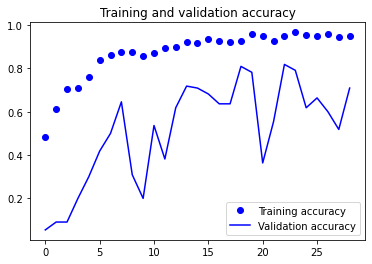

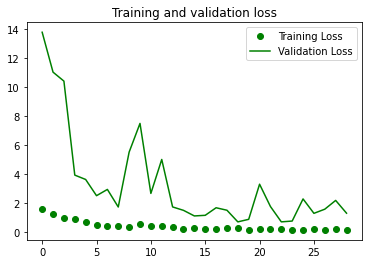

In [47]:
acc = inceptioinV3_history.history['accuracy']
val_acc = inceptioinV3_history.history['val_accuracy']
loss = inceptioinV3_history.history['loss']
val_loss = inceptioinV3_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## transfer learning - inception v3 , fine tunning

In [49]:
inceptioinV3 = tf.keras.applications.InceptionV3(weights='imagenet',input_shape=(299,299,3), include_top=True)

for layer in inceptionV3.layers[:]:
  layer.trainable = True

base_inputs = inceptionV3.layers[0].input
base_outputs = inceptionV3.layers[-2].output
classifier = tf.keras.layers.Dense(11)(base_outputs)
inceptionV3_ft_model = tf.keras.Model(inputs=base_inputs, outputs=classifier)

inceptionV3_ft_model.summery()

NameError: ignored

In [ ]:
inceptionV3_ft_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [ ]:
checkpoint_path = '/content/drive/MyDrive/ktintern/models/'
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_path, 'inceptionV3_ft_model.ckpt'),
                                                   save_weights_only=True,
                                                   monitor = 'val_loss',
                                                   verbose=1,
                                                   save_best_only=True
                                                  ) 

In [ ]:
inceptioinV3_ft_history = inceptionV3_ft_model.fit(train_generator,
                                                   validation_data=validation_generator,
                                                   epochs=30,
                                                   callbacks=[cb_checkpoint, early_stopping]
                                                   )

In [ ]:
acc = inceptioinV3_ft_history.history['accuracy']
val_acc = inceptioinV3_ft_history.history['val_accuracy']
loss = inceptioinV3_ft_history.history['loss']
val_loss = inceptioinV3_ft_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()